# 倒水问题
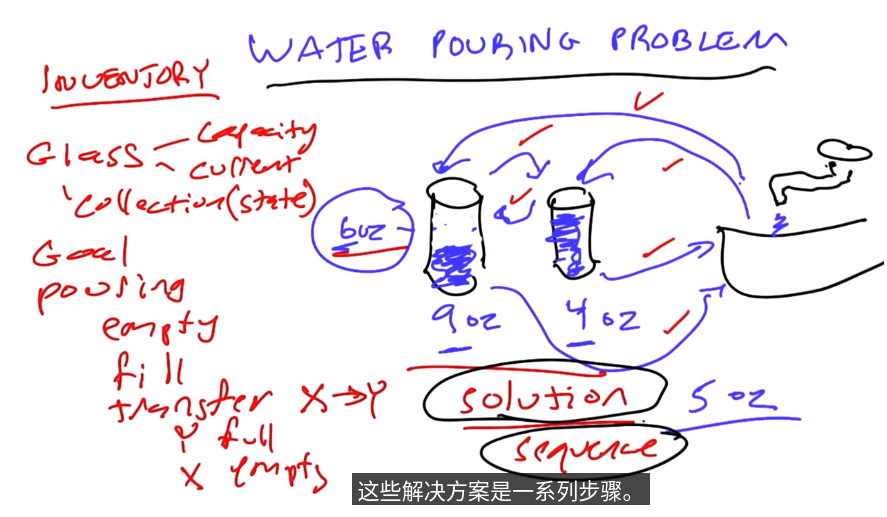
管理复杂性:动作序列(sequences are long）
## Combinatorial Complexity 组合复杂性 
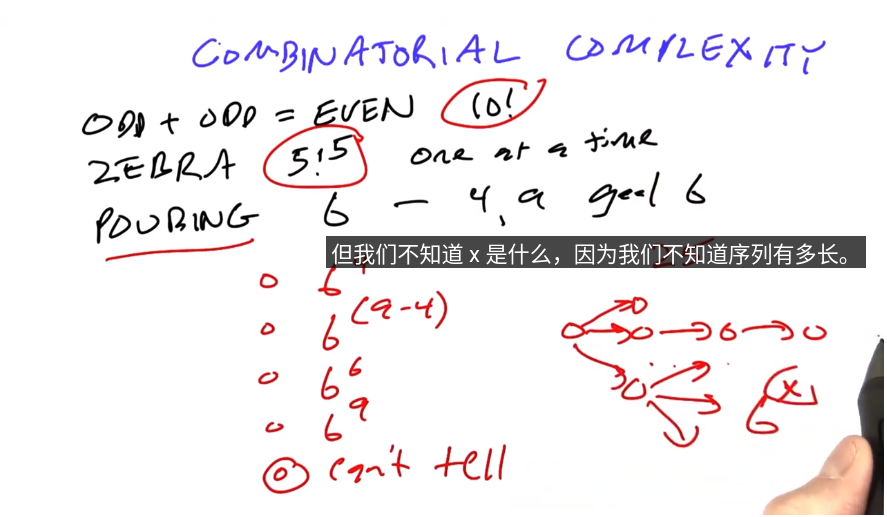
这是个[组合优化](https://en.wikipedia.org/wiki/Combinatorial_optimization)
问题或者说搜索问题
## 探索空间
两个问题:
1. 开始状态到目标状态 有解？ 
2. 效率 避免死循环 （最短优先，不重复探索)
术语：successores 一个状态通过对应的步骤产生的状态和步骤

In [2]:

def pour_problem(X,Y,goal,start=(0,0)):
    "XY是容量 xy当前容量"
    if goal in start:return [start]
    explored = set()
    frontier = [[start]]
    while frontier:
        #print("++"*10)
        path = frontier.pop(0) # 移除第一个元素
        #print('path=',path)
        #print('f=',frontier)
        (x,y) = path[-1] #Last state in the first path of the frontier
        for (state,action) in successors(x,y,X,Y).items():
            if state not in explored:
                explored.add(state)
                path2 = path+[action,state]
                if goal in state:
                    return path2
                else:
                    frontier.append(path2)
                    #print('fl=',frontier)
        #print('e=',explored)
        #print("=="*10)
    return Fail
Fail=[]

def successors(x,y,X,Y):
    """return a dict of {state:action} pairs descrbing what can be reached 
    from the (x,y) state ,and how
    """
    assert(x<=X) and y<=Y ## (x,y) is glass levels; X and Y are glass sizes
    return {((0,y+x) if y+x<=Y else (x-(Y-y),y+(Y-y))):'X->Y',
            ((x+y,0) if x+y<=X else (x+(X-x),y-(X-x))):'X->Y',
            (X,y):'fill X',(x,Y):'fill Y',
            (0,y):'empty X',(x,0):'empty Y'}
print(pour_problem(4,9,7))

[(0, 0), 'fill X', (4, 0), 'X->Y', (0, 4), 'fill X', (4, 4), 'X->Y', (0, 8), 'fill X', (4, 8), 'X->Y', (3, 9), 'empty Y', (3, 0), 'X->Y', (0, 3), 'fill X', (4, 3), 'X->Y', (0, 7)]


# 过桥问题
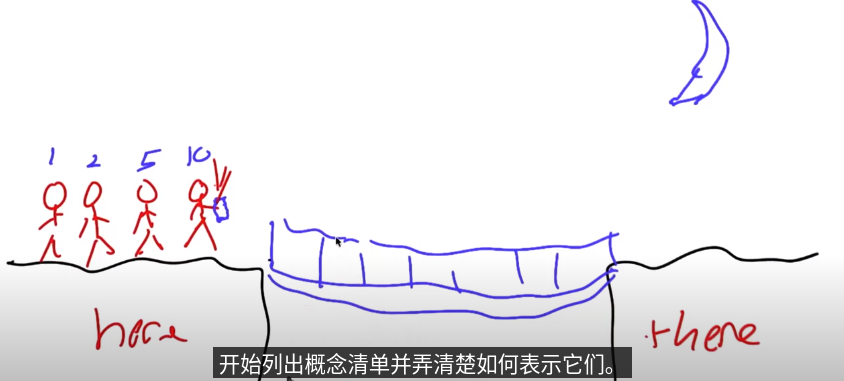

这同样是搜索问题
- state: (here,there,elapsed_time)
- seccessors 继任者应当是可hash的 here,there

# Generalizing 用最短路径问题概括搜索问题(不是最佳成本搜索)
概念：
- paths
    - [state,action,state,..,state]
- states start_state 
- actions
- successors: (state)-> {state:action}
- goal: (state)-> bool
- __action-cost__

In [26]:
def bsuccessors(state):
    here,there,t = state
    here, there, t = state
    if 'light' in here:
        return dict(((here - frozenset([a,b,'light']),
                    there | frozenset([a,b,'light']),
                      t+max(a,b)),(a,b,'->'))
                    for a in here if a != 'light'
                    for b in here if b != 'light'
                    )
    else:
        return dict(((here | frozenset([a,b,'light']),
                     there - frozenset([a,b,'light']),
                     t + max(a,b)),(a,b,'<-'))
                   for a in there if a != 'light'
                   for b in there if b != 'light')

def test():
    assert bsuccessors((frozenset([1, 'light']), frozenset([]), 3)) == {
                (frozenset([]), frozenset([1, 'light']), 4): (1, 1, '->')}

    assert bsuccessors((frozenset([]), frozenset([2, 'light']), 0)) =={
                (frozenset([2, 'light']), frozenset([]), 2): (2, 2, '<-')}
    
    return 'tests pass'

test()

'tests pass'

In [27]:
def path_states(path):
    return path[0::2]

def path_actions(path):
    return path[1::2]

In [30]:
Fail = []
def bridge_problem(here):
    here = frozenset(here)|frozenset(['light'])
    explored = set()
    frontier = [[(here,frozenset(),0)]]
    if not here:
        return frontier[0]
    while frontier:
        path = frontier.pop(0)
        here1,there1,t1 = state1 = path[-1]
        if not here1 or here1 == set(['light']):
            return path
        for (state,action) in bsuccessors(state1).items():
            if state not in explored:
                here,there,t=state
                explored.add(state)
                path2 = path+[action,state]
                frontier.append(path2)
                frontier.sort(key=elapsed_time)# 优先处理耗时短的
    return Fail
def elapsed_time(path):
    return path[-1][2]

path_actions(bridge_problem([1,2,5,10]))

[(2, 1, '->'), (1, 1, '<-'), (5, 10, '->'), (2, 2, '<-'), (2, 1, '->')]

In [43]:
def bsuccessors2(state):
    here,there = state
    if 'light' in here:
        return dict(((here - frozenset([a,b,'light']),
                     there | frozenset([a,b,'light'])),
                    (a,b,'->'))
                    for a in here if a != 'light'
                    for b in here if b != 'light'
                    )
                    
    else:
        return dict(((here | frozenset([a,b,'light']),
                     there - frozenset([a,b,'light'])),
                     (a,b,'<-'))
                   for a in there if a != 'light'
                   for b in there if b != 'light')
                    

def path_cost(path):
    # path = (state, (action, total_cost), state, ...,state )
    if len(path)<3:
        return 0
    else:
        _,total_cost = path[-2]
        return total_cost

def bcost(action):
    a,b,arrow = action
    return max(a,b)

def final_state(path): return path[-1]

def bridge_problem2(here):
    here = frozenset(here)|frozenset(['light'])
    explored = set()
    frontier = [ [(here,frozenset())]]
    while frontier:
        path = frontier.pop(0)
        here1,there1 = state1 = final_state(path)
        if not here1 or ((len(here)==1) and 'light'in here):
            return path
        explored.add(state1)
        # 跟踪成本
        pcost = path_cost(path)
        for (state,action) in bsuccessors2(state1).items():
            if state not in explored:
                total_cost = pcost + bcost(action)
                path2 = path + [(action,total_cost),state]
                add_to_frontier(frontier,path2)
    return Fail
def add_to_frontier(frontier,path):
    "add path to frontier,replacing costlier path is there is one"
    old =None
    for i,p in enumerate(frontier):
        if p[-1] == path[-1]:
            old=i
            break
    if old is not None and path_cost(frontier[old])< path_cost(path):
        return #old path was better
    elif old is not None:
        del frontier[old] #old path was worse
    frontier.append(path)

bridge_problem2(frozenset((1, 2, 5, 10),))

[(frozenset({1, 10, 2, 5, 'light'}), frozenset()),
 ((2, 1, '->'), 2),
 (frozenset({5, 10}), frozenset({1, 2, 'light'})),
 ((2, 2, '<-'), 4),
 (frozenset({10, 2, 5, 'light'}), frozenset({1})),
 ((5, 10, '->'), 14),
 (frozenset({2}), frozenset({1, 10, 5, 'light'})),
 ((1, 1, '<-'), 15),
 (frozenset({1, 2, 'light'}), frozenset({5, 10})),
 ((2, 1, '->'), 17),
 (frozenset(), frozenset({1, 10, 2, 5, 'light'}))]

## 乘船过河
- 3个食人魔,3个传教士,船(载重2人)，两边食人魔数量大于传教士会被吃

In [69]:
def csuccessors(state):
    M1,C1,B1,M2,C2,B2 = state
    if C1>M1>0 or C2>M2>0:
        return {}
    items = []
    if B1==1:
        items += [(sub(state,d),a+'->') for d,a in delta.items()]
    elif B2 == 1:
        items += [(add(state,d),'<-'+a) for d,a in delta.items()]
    # 剔除<0 
    items = filter(lambda x:False not in [j>=0 for j in x[0]] ,items)
        
    return dict(items)

delta = {(2, 0, 1,    -2, 0, -1): 'MM', 
        (0, 2, 1,     0, -2, -1): 'CC', 
        (1, 1, 1,     -1, -1, -1): 'MC', 
        (1, 0, 1,     -1, 0, -1): 'M', 
        (0, 1, 1,      0, -1, -1): 'C'}

def add(X,Y):
    return tuple(x+y for x,y in zip(X,Y))
def sub(X,Y):
    return tuple(x-y for x,y in zip(X,Y))

def test():
    assert csuccessors((2, 2, 1, 0, 0, 0)) == {(2, 1, 0, 0, 1, 1): 'C->', 
                                               (1, 2, 0, 1, 0, 1): 'M->', 
                                               (0, 2, 0, 2, 0, 1): 'MM->', 
                                               (1, 1, 0, 1, 1, 1): 'MC->', 
                                               (2, 0, 0, 0, 2, 1): 'CC->'}
    assert csuccessors((1, 1, 0, 4, 3, 1)) == {(1, 2, 1, 4, 2, 0): '<-C', 
                                               (2, 1, 1, 3, 3, 0): '<-M', 
                                               (3, 1, 1, 2, 3, 0): '<-MM', 
                                               (1, 3, 1, 4, 1, 0): '<-CC', 
                                               (2, 2, 1, 3, 2, 0): '<-MC'}
    assert csuccessors((1, 4, 1, 2, 2, 0)) == {}
    print('tests pass')


test()
csuccessors((2, 0, 1, 0, 0, 0))

tests pass


{(0, 0, 0, 2, 0, 1): 'MM->', (1, 0, 0, 1, 0, 1): 'M->'}

In [71]:
def mc_problem(start=(3,3,1,0,0,0),goal=None):
    """
    """
    if goal is None:
        goal = (0,0,0)+start[:3]
    if start == goal:
        return start
    explored = set()
    frontier = [[start]]
    while frontier:
        path = frontier.pop(0)
        s = path[-1]
        for state,action in csuccessors(s).items():
            if state not in explored:
                explored.add(state)
                path2 = path + [action,state]
                if state == goal:
                    return path2
                else:
                    frontier.append(path2)
    return []
mc_problem()

[(3, 3, 1, 0, 0, 0),
 'CC->',
 (3, 1, 0, 0, 2, 1),
 '<-C',
 (3, 2, 1, 0, 1, 0),
 'CC->',
 (3, 0, 0, 0, 3, 1),
 '<-C',
 (3, 1, 1, 0, 2, 0),
 'MM->',
 (1, 1, 0, 2, 2, 1),
 '<-MC',
 (2, 2, 1, 1, 1, 0),
 'MM->',
 (0, 2, 0, 3, 1, 1),
 '<-C',
 (0, 3, 1, 3, 0, 0),
 'CC->',
 (0, 1, 0, 3, 2, 1),
 '<-M',
 (1, 1, 1, 2, 2, 0),
 'MC->',
 (0, 0, 0, 3, 3, 1)]

# 模板 

In [78]:
def shortest_path_search(start,successors,is_goal):
    if is_goal(start):
        return [start]
    explored = set()
    frontier = [[start]]
    while frontier:
        path = frontier.pop(0)
        s = path[-1]
        for (state,action) in successors(s).items():
            if state not in explored:
                explored.add(state)
                path2 = path + [action,state]
                if is_goal(state):
                    return path2
                else:
                    frontier.append(path2)
    return Fail

def all_gone(state):return state[:3] == (0,0,0)


def mc_problem2(start=(3, 3, 1, 0, 0, 0), goal=None):
    """Solve the missionaries and cannibals problem.
    State is 6 ints: (M1, C1, B1, M2, C2, B2) on the start (1) and other (2) sides.
    Find a path that goes from the initial state to the goal state (which, if
    not specified, is the state with no people or boats on the start side."""
    if goal is None:
        def goal_fn(state): return state[:3] == (0, 0, 0)
    else:
        def goal_fn(state): return state == goal
    return shortest_path_search(start, csuccessors, goal_fn)

mc_probelem2()

[(3, 3, 1, 0, 0, 0),
 'CC->',
 (3, 1, 0, 0, 2, 1),
 '<-C',
 (3, 2, 1, 0, 1, 0),
 'CC->',
 (3, 0, 0, 0, 3, 1),
 '<-C',
 (3, 1, 1, 0, 2, 0),
 'MM->',
 (1, 1, 0, 2, 2, 1),
 '<-MC',
 (2, 2, 1, 1, 1, 0),
 'MM->',
 (0, 2, 0, 3, 1, 1),
 '<-C',
 (0, 3, 1, 3, 0, 0),
 'CC->',
 (0, 1, 0, 3, 2, 1),
 '<-M',
 (1, 1, 1, 2, 2, 0),
 'MC->',
 (0, 0, 0, 3, 3, 1)]

In [77]:
def lowest_cost_search(start,successors,is_goal,action_cost):
    if is_goal(start):
        return [start]
    explored = set()
    frontier = [ [start]]
    while frontier:
        path = frontier.pop(0)
        state1 = final_state(path)
        if is_goal(state1):
            return path
        explored.add(state1)
        # 跟踪成本
        pcost = path_cost(path)
        for (state,action) in successors(state1).items():
            if state not in explored:
                total_cost = pcost + action_cost(action)
                path2 = path + [(action,total_cost),state]
                add_to_frontier(frontier,path2)
    return Fail


def all_over(state):
    here, there = state
    return not here or here == set(['light'])

def bridege_problem3(here):
    start = (frozenset(here)|frozenset(['light']),frozenset())
    return lowest_cost_search(start,bsuccessors2,all_over,bcost)

bridege_problem3(frozenset((1, 2, 5, 10),))

[(frozenset({1, 10, 2, 5, 'light'}), frozenset()),
 ((2, 1, '->'), 2),
 (frozenset({5, 10}), frozenset({1, 2, 'light'})),
 ((2, 2, '<-'), 4),
 (frozenset({10, 2, 5, 'light'}), frozenset({1})),
 ((5, 10, '->'), 14),
 (frozenset({2}), frozenset({1, 10, 5, 'light'})),
 ((1, 1, '<-'), 15),
 (frozenset({1, 2, 'light'}), frozenset({5, 10})),
 ((2, 1, '->'), 17),
 (frozenset(), frozenset({1, 10, 2, 5, 'light'}))]

# 作业
## 修改过桥代码

In [83]:
def bsuccessors3(state,travelers):
    _,_,light = state
    start = state[light]-travelers
    dest = state[1-light] | travelers
    if light == 0: #light is here
        return (start,dest,1),(travelers,'->')
    else:
        return (dest,start,0),(travelers,'<-')
    
def test():
    assert bsuccessors3((frozenset([1]), frozenset([]), 0)) == {
            (frozenset([]), frozenset([1]), 1)  :  (set([1]), '->')}

    assert bsuccessors3((frozenset([1, 2]), frozenset([]), 0)) == {
            (frozenset([1]), frozenset([2]), 1)    :  (set([2]), '->'), 
            (frozenset([]), frozenset([1, 2]), 1)  :  (set([1, 2]), '->'), 
            (frozenset([2]), frozenset([1]), 1)    :  (set([1]), '->')}

    assert bsuccessors3((frozenset([2, 4]), frozenset([3, 5]), 1)) == {
            (frozenset([2, 4, 5]), frozenset([3]), 0)   :  (set([5]), '<-'), 
            (frozenset([2, 3, 4, 5]), frozenset([]), 0) :  (set([3, 5]), '<-'), 
            (frozenset([2, 3, 4]), frozenset([5]), 0)   :  (set([3]), '<-')}
    print('tests pass')

# test()

In [85]:
# 四个试管倒水
def more_pour_problem(capacities, goal, start=None):
    pass
    

    
def test_more_pour():
    assert more_pour_problem((1, 2, 4, 8), 4) == [
        (0, 0, 0, 0), ('fill', 2), (0, 0, 4, 0)]
    assert more_pour_problem((1, 2, 4), 3) == [
        (0, 0, 0), ('fill', 2), (0, 0, 4), ('pour', 2, 0), (1, 0, 3)] 
    starbucks = (8, 12, 16, 20, 24)
    assert not any(more_pour_problem(starbucks, odd) for odd in (3, 5, 7, 9))
    assert all(more_pour_problem((1, 3, 9, 27), n) for n in range(28))
    assert more_pour_problem((1, 3, 9, 27), 28) == []
    return 'test_more_pour passes'

# print test_more_pour()

In [86]:
# 地铁规划